## This practical is to collect resources for creating knowledge graph. Our aim is to create a knowledge graph from unstructured data such as text on web. To do that, the first step is to collect resources from web; this is the main objective of this practical.

### As this is going to deal with text data, Natural Language Processing (NLP) techniques will have to be used. It is not necessary to know much about NLP for our task as we aim is not to study NLP. Instead, it is only required to know how to use some NLP tools.

### Under the current Covid-19 pandemic, in this exercise we want to know more in general about the pandemic. For example, what and when are the pandemics happened in the past, i.e., the notable outbreaks? To understand that, we want to crawl the web sources such as news and wikipedia. As an example, in this practical we only look at a wikipedia source: https://en.wikipedia.org/wiki/Pandemic. For crawling more web pages, some tools may have to be used, for example, the NewsAPI (https://newsapi.org/).

### Our goal in this practical is to convert the text in this web site into a Knowledge Graph. The first step is to extract the whole text from this web site. Given this web source, we can use the Requests module to read all the information from this resource. For information how to use Requests, please refer to https://requests.readthedocs.io/en/master/.

In [1]:
import requests
url = 'https://en.wikipedia.org/wiki/Pandemic'
res = requests.get(url)
html_page = res.content


### All the information is obtained, NLP tools now can be used to extract the text.

In [2]:
import bs4
soup = bs4.BeautifulSoup(html_page, 'html.parser')
all_text = soup.get_text() # get all the text.


### We can then make text to sentences and save them to a csv file.

In [3]:
import nltk
nltk.download('punkt')
from nltk import tokenize

sentences = tokenize.sent_tokenize(all_text) # make text to sentences.
#print(sentences)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mingjun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import csv

with open('output.csv', 'w', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['sentence'])
    for row in sentences:
        writer.writerow([str(row)])

### However, you might have noticed that the data need to be cleaned. Some sentences are not informative and thus need to be removed.

### Now try to create a knowledge graph

In [6]:
# import the sentences from .csv file
import pandas as pd
example_sentences = pd.read_csv("output.csv", encoding= 'unicode_escape')
example_sentences.shape
print(example_sentences)

                                               sentence
0     \r\n\r\n\r\n\r\nPandemic - Wikipedia\r\n\r\n\r...
1        For other uses, see Pandemic (disambiguation).
2     Global epidemic of infectious disease\r\n\r\n\...
3     Painting by Michel Serre during the Great Plag...
4     [1] Hotels and dormitories were also considere...
...                                                 ...
1158  vteGlobal catastrophic risks\r\nFuture of the ...
1159  Text is available under the Creative Commons A...
1160  By using this site, you agree to the Terms of ...
1161  WikipediaÂ® is a registered trademark of the W...
1162  Privacy policy\r\nAbout Wikipedia\r\nDisclaime...

[1163 rows x 1 columns]


### Take a few examples to see the Subject, Predicate and Object

In [9]:
sents = example_sentences['sentence'].sample(2)
print(sents)

211    Estimates for the mortality of this pandemic r...
66     In 2006, the HIV prevalence among pregnant wom...
Name: sentence, dtype: object


In [12]:
import spacy
nlp=spacy.load('en_core_web_sm')
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]


In [18]:
get_entities("This is an example of knowledge graph")

['This', 'knowledge graph']

In [1]:
from tqdm import tqdm
entity_pairs = []
for i in tqdm(example_sentences["sentence"]):    
    if type(i) != float:
        entity_pairs.append(get_entities(i))

NameError: name 'example_sentences' is not defined

In [21]:
entity_pairs[0:10]

[['article', 'pandemics'],
 ['', 'other  Pandemic'],
 ['', 'mass Chevalier burial'],
 ['COVID-19 convention centers', 'existing  infrastructure'],
 ['also  they', 'negative pressure technology'],
 ['infectious Greek that', 'substantial  people'],
 ['widespread endemic disease', 'infected  people'],
 ['generally  they', 'large  globe'],
 ['', 'such  smallpox'],
 ['also Black which', '14th 75â\x80\x93200 century']]

### Extract the predicates

In [24]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)


In [25]:
get_relation("This is an example of knowledge graph")

'is'

In [26]:
#relations = [get_relation(i) for i in tqdm(example_sentences['[64]'])]
relations = []
for i in tqdm(example_sentences['sentence']):
    if type(i) != float:
        relations.append(get_relation(i))

100%|█████████████████████████████████████████████████████████████████████████████| 1163/1163 [00:10<00:00, 110.06it/s]


In [27]:
pd.Series(relations).value_counts()[:10]

Retrieved        72
^                56
PMIDÂ            32
Archived from    28
PMCÂ             19
killed           15
is               14
was              13
Journal of       11
Worldometer      11
dtype: int64

### Create the triples and store in a dataframe

In [29]:
subjects = [item[0] for item in entity_pairs]
objects = [item[1] for item in entity_pairs]
df_graph = pd.DataFrame({'subjects':subjects, 'objects':objects, 'edge':relations})
print(df_graph)

                                     subjects                         objects  \
0                                     article                       pandemics   
1                                                             other  Pandemic   
2                                                       mass Chevalier burial   
3                 COVID-19 convention centers        existing  infrastructure   
4                                  also  they    negative pressure technology   
...                                       ...                             ...   
1158                              ° Edit page                    2021  03:51Â   
1159  additional Attribution ShareAlike terms  Attribution ShareAlike License   
1160                                      you                             Use   
1161                               WikipediaÂ                Foundation  Inc.   
1162                                                      Mobile Contact view   

                        edg

### We can use networkx to draw a directed graph for these triples

In [31]:
import networkx as nx

In [32]:
G=nx.from_pandas_edgelist(df_graph, "subjects", "objects", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

### We can print the graph

d:\Users\Mingjun\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\Mingjun\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\Mingjun\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\Mingjun\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Users\Mingjun\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
d:\Users\Mingjun\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 147 missing from cur

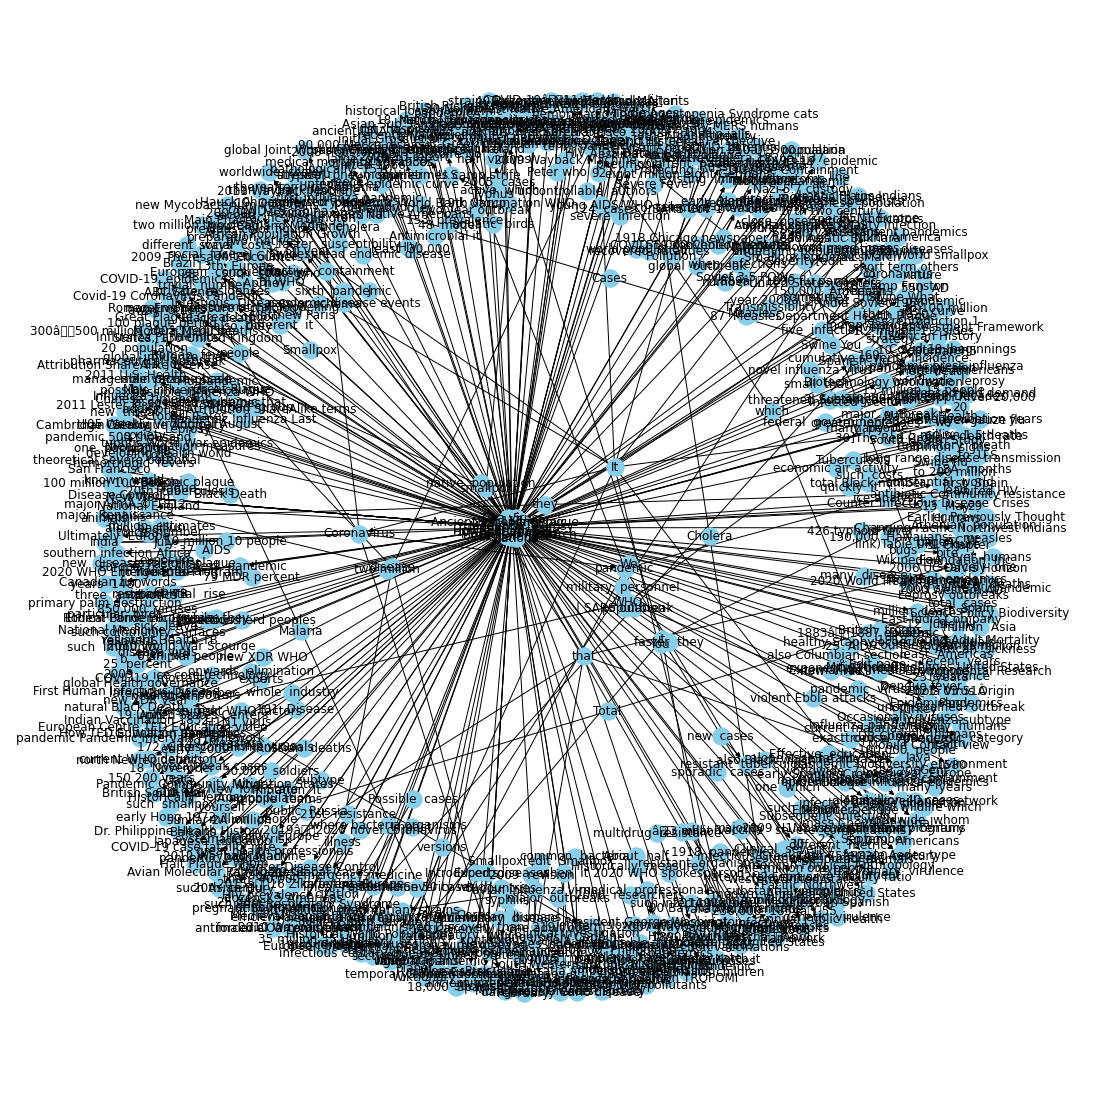

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

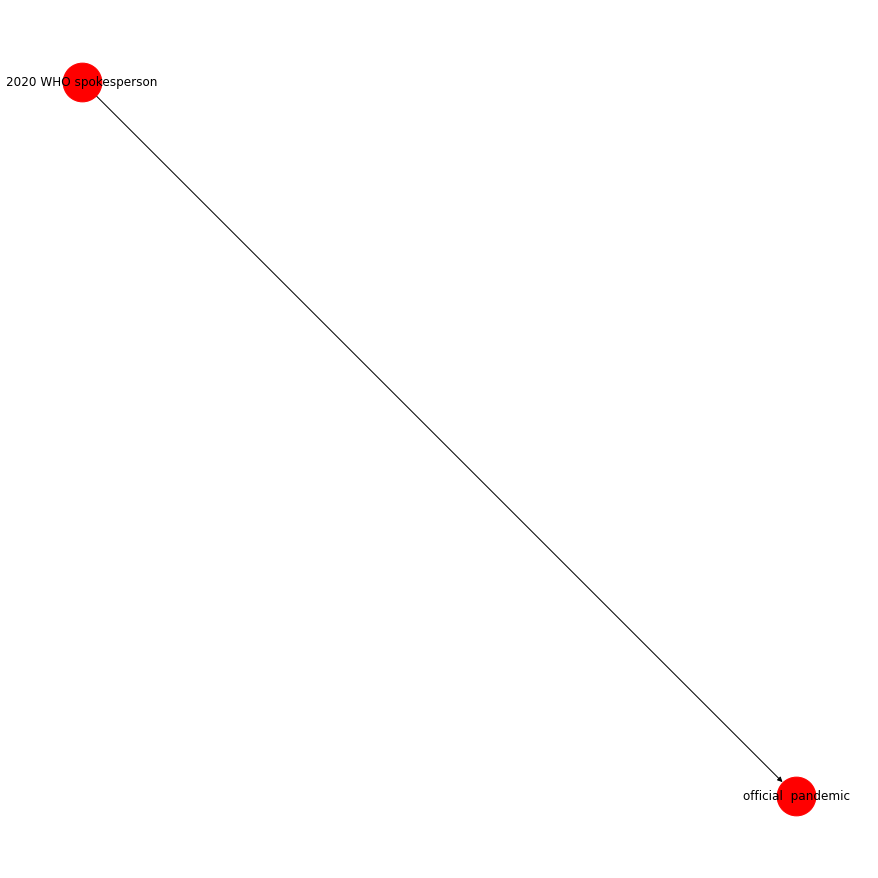

In [43]:
G=nx.from_pandas_edgelist(df_graph[df_graph['edge']=="clarified"], "subjects", "objects", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
print(G)
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()